# Predicting future attention for a business

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline
pd.options.display.mpl_style = 'default'

pd.set_option('display.max_columns', 36)
print pd.__version__

0.18.0


C:\Users\kritz\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


First we'll use NLTK to preprocess and tokenize text data

In [8]:
import nltk
import string
from nltk import word_tokenize
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter



Download extra stopwords and sentiment/opinion datasets in case we may use it later on

In [9]:
%%bash
# thank you Kevin Bouge http://sites.google.com/site/kevinbouge/stopwords-lists
wget --quiet --output-document=more_stopwords.txt http://sites.google.com/site/kevinbouge/stopwords-lists/stopwords_en.txt?attredirects=0&d=1

# http://www2.cs.uic.edu/~liub/
# Hu, Minqing, and Bing Liu. "Mining and summarizing customer reviews." Proceedings of the tenth ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2004.
# Liu, Bing, Minqing Hu, and Junsheng Cheng. "Opinion observer: analyzing and comparing opinions on the web." Proceedings of the 14th international conference on World Wide Web. ACM, 2005.
wget --quiet --output-document=opinions.rar http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
unrar e -o+ --silent opinions.rar > /dev/null
sed -i '/^;/d' positive-words.txt
sed -i '/^;/d' negative-words.txt

Couldn't find program: u'bash'


In [10]:
POSITIVE_WORDS = set([line.strip() for line in open('positive-words.txt', 'r')])
NEGATIVE_WORDS = set([line.strip() for line in open('negative-words.txt', 'r')])
NLTK_STOPWORDS = set(stopwords.words('english'))
MORE_STOPWORDS = set([line.strip() for line in open('more_stopwords.txt', 'r')])

def remove_numbers_in_string(s):
    return s.translate(None, string.digits)

def lowercase_remove_punctuation(s):
    s = s.lower()
    s = s.translate(None, string.punctuation)
    return s
    
def remove_stopwords(s):
    token_list = nltk.word_tokenize(s)
    exclude_stopwords = lambda token : token not in NLTK_STOPWORDS
    return ' '.join(filter(exclude_stopwords, token_list))

def filter_out_more_stopwords(token_list):
    return filter(lambda tok : tok not in MORE_STOPWORDS, token_list)

def stem_token_list(token_list):
    STEMMER = PorterStemmer()
    return [STEMMER.stem(tok.decode('utf-8')) for tok in token_list]

def restring_tokens(token_list):
    return ' '.join(token_list)

def lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring(s):
    s = remove_numbers_in_string(s)
    s = lowercase_remove_punctuation(s)
    s = remove_stopwords(s)
    token_list = nltk.word_tokenize(s)
    token_list = filter_out_more_stopwords(token_list)
    token_list = stem_token_list(token_list)
    return restring_tokens(token_list)

Use TURBO dataset from DataWrangling and EDA notebooks

In [11]:
turbo_csv_filename = os.path.join("./", 'turbo_predict.csv')
TURBO_DF = pd.read_csv(turbo_csv_filename)


In [12]:
for idx in range(5):
    print TURBO_DF.review_text[idx]
    print

big guy fine job make strip mall bar potenti favorit servic fast friendli eat friend food look smell high qualiti drink price good pour eclect crowd gentl manner bit fun bathroom clean uncrowd flat screen tv varieti event open atmospher cleanli welcom feel tabl mildli sticki paint nonclublik bar chill feel place good crowd thursday fit walk life pint great beer select cheer ya

neg review close thought give staff nice run promot favorit sandwich didnt notic slow servic nice place

order onlin pick order grill chicken pizza buffalo wing great price great custom servic food good

vye desert mission food bank yelper stuck grab brunch someplac sunnyslop lot option chose im proud fellow yelper decid place review eye open famili restaur tom tini phoenix familyown diner open day week pm breakfast lunch morn ritual sunnyslop longtim resid favorit thing sunnyslop small town feel access urban amen phoenix place eye open feed sens place hal owner kind man love liabl tabl fill coffe cup make evid 

In [13]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text','business_review_count','business_attention']
df_with_initial_features_and_preprocessed_review_text = TURBO_DF[initial_features]
%time df_with_initial_features_and_preprocessed_review_text['review_text'] = df_with_initial_features_and_preprocessed_review_text['review_text'].apply(lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)

for idx in range(5):
    print df_with_initial_features_and_preprocessed_review_text.review_text[idx]
    print

Wall time: 2.18 s
big guy fine job make strip mall bar potenti favorit servic fast friendli eat friend food smell high qualiti drink price good pour eclect crowd gentl manner bit fun bathroom clean uncrowd flat screen tv varieti event open atmosph cleanli welcom feel tabl mildli sticki paint nonclublik bar chill feel place good crowd thursday fit walk life pint great beer select cheer ya

neg review close thought give staff nice run promot favorit sandwich didnt notic slow servic nice place

order onlin pick order grill chicken pizza buffalo wing great price great custom servic food good

vye desert mission food bank yelper stuck grab brunch someplac sunnyslop lot option chose im proud fellow yelper decid place review eye open famili restaur tom tini phoenix familyown diner open day week pm breakfast lunch morn ritual sunnyslop longtim resid favorit thing sunnyslop small town feel access urban amen phoenix place eye open feed sen place hal owner kind man love liabl tabl fill coff cup m

C:\Users\kritz\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Next, import sklearn functions and partition the data into training and test subsets

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import numpy as np
from numpy import genfromtxt, savetxt
import sys
import random

training_labels = genfromtxt(open('training2.csv','r'), delimiter=',', usecols=0, dtype=str)[0:]
training_data = genfromtxt(open('training2.csv','r'), delimiter=',', dtype='f8')[:,1:]

test_labels = genfromtxt(open('testing2.csv','r'), delimiter=',', usecols=0, dtype=str)[0:]
test_data = genfromtxt(open('testing2.csv','r'), delimiter=',', dtype='f8')[:,1:]


















Visualize through Confusion Matrix

In [16]:
def make_confusion_matrix_relative(confusion_matrix):
    star_category_classes = [1, 2, 3, 4, 5]
    N = [1, 2, 3, 4, 5]
    relative_confusion_matrix = np.empty((len(star_category_classes), len(star_category_classes)))
    
    for j in range(0, len(star_category_classes)):
        if N[j] > 0:
            relative_frequency = confusion_matrix[j, :] / float(N[j])
            relative_confusion_matrix[j, :] = relative_frequency
            
    return relative_confusion_matrix

# http://www.wenda.io/questions/4330313/heatmap-with-text-in-each-cell-with-matplotlibs-pyplot.html
# http://stackoverflow.com/questions/20520246/create-heatmap-using-pandas-timeseries
# http://sebastianraschka.com/Articles/heatmaps_in_r.html
# http://code.activestate.com/recipes/578175-hierarchical-clustering-heatmap-python/
def plot_confusion_matrix(confusion_matrix=[[]], title='CM', savefilename=''):
    rcm = make_confusion_matrix_relative(confusion_matrix)
    #plt.imshow(rcm, vmin=0, vmax=1, interpolation='nearest')
    c = plt.pcolor(rcm, edgecolors='k', linewidths=4, cmap='jet', vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))

    def show_values(pc, fmt="%.2f", **kw):
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if sum(color[:2] > 0.3) >= 2:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)

    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight')
    
    return plt.show()

Print classifier performance metrics

In [17]:
def print_classifier_performance_metrics(name, predictions):
    target_names = ['very low', 'low', 'medium', 'high', 'very high']
    
    print "MODEL: %s" % name
    print

    print 'Precision: ' + str(metrics.precision_score(test_labels, predictions))
    print 'Recall: ' + str(metrics.recall_score(test_labels, predictions))
    print 'F1: ' + str(metrics.f1_score(test_labels, predictions))
    print 'Accuracy: ' + str(metrics.accuracy_score(test_labels, predictions))

    print
    print 'Classification Report:'
    print classification_report(test_labels, predictions, target_names=target_names)
    
    print
    print 'Precision variance: %f' % np.var(precision_score(test_labels, predictions, average=None), ddof=len(target_names)-1)
    
    print
    print 'Recall variance: %f' % np.var(recall_score(test_labels, predictions, average=None), ddof=len(target_names)-1)

### Random Forest 100 Learners Model

In [18]:
forest100 = RandomForestClassifier(n_estimators = 100, random_state=42)

Transform Yelp reviews into feature vectors

Make predictions with random forest set at 100 learners

In [19]:
%time forest100.fit(training_data, training_labels)
forest100_pred = forest100.predict(test_data)
np.save('forest100pred', forest100_pred)

Wall time: 305 ms


Visualize results in confusion matrix

C:\Users\kritz\Anaconda2\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


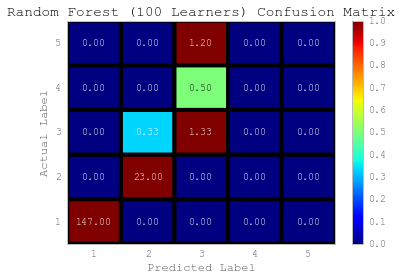

In [20]:
random_forest_confusion_matrix = confusion_matrix(test_labels, forest100_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix',
                      savefilename='RandomForestCM.png')

In [77]:
print_classifier_performance_metrics('Random Forest (100 Learners)', forest100_pred)

MODEL: Random Forest (100 Learners)

Precision: 0.940232734284
Recall: 0.956310679612
F1: 0.945914162721
Accuracy: 0.956310679612

Classification Report:
             precision    recall  f1-score   support

   very low       1.00      1.00      1.00       147
        low       0.98      1.00      0.99        46
     medium       0.33      0.80      0.47         5
       high       0.00      0.00      0.00         2
  very high       0.00      0.00      0.00         6

avg / total       0.94      0.96      0.95       206


Precision variance: 0.999889

Recall variance: 1.072000


C:\Users\kritz\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\kritz\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

### SVC Model

Initialize feature vector and SVC model

In [78]:
svc_feature_matrix_train = training_data
svc_feature_matrix_test = test_data

svc = SVC()

Train SVC model

In [79]:
%time svc.fit(svc_feature_matrix_train, training_labels) 

Wall time: 878 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [80]:
%time svc_predictions = svc.predict(svc_feature_matrix_test)
np.save('svcPred', svc_predictions)

Wall time: 38 ms


In [81]:
if os.path.isfile('svcPred.npy'):
    svc_predictions = np.load('svcPred.npy')

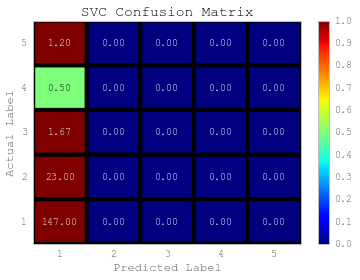

In [82]:
svc_confusion_matrix = confusion_matrix(test_labels, svc_predictions)
plot_confusion_matrix(svc_confusion_matrix, 'SVC Confusion Matrix', savefilename='SVC_CM.png')

In [83]:
print_classifier_performance_metrics('SVC', svc_predictions)

MODEL: SVC

Precision: 0.509213875012
Recall: 0.71359223301
F1: 0.594323276218
Accuracy: 0.71359223301

Classification Report:
             precision    recall  f1-score   support

   very low       0.71      1.00      0.83       147
        low       0.00      0.00      0.00        46
     medium       0.00      0.00      0.00         5
       high       0.00      0.00      0.00         2
  very high       0.00      0.00      0.00         6

avg / total       0.51      0.71      0.59       206


Precision variance: 0.407371

Recall variance: 0.800000


C:\Users\kritz\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\kritz\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import numpy as np
from numpy import genfromtxt, savetxt
import sys
import random

def print_misclassification_error():
	training_labels = genfromtxt(open('training2.csv','r'), delimiter=',', usecols=0, dtype=str)[0:]
	training_data = genfromtxt(open('training2.csv','r'), delimiter=',', dtype='f8')[:,1:]

	test_labels = genfromtxt(open('testing2.csv','r'), delimiter=',', usecols=0, dtype=str)[0:]
	test_data = genfromtxt(open('testing2.csv','r'), delimiter=',', dtype='f8')[:,1:]

	#RandomForest

	rf = RandomForestClassifier(n_estimators=100)
	rf.fit(training_data,training_labels)

	predict_rf = rf.predict(test_data)
	print predict_rf
	actual = np.array(test_labels)
	predicted_rf = np.array(predict_rf)

	error_rf = np.sum(actual!=predicted_rf)

	#SVM

	clf = svm.SVC(C=0.001,kernel="linear")
	clf.fit(training_data,training_labels)
	predict_svm = clf.predict(test_data)
	predicted_svm = np.array(predict_svm)
	
	#print predicted_svm
	error_svm = np.sum(actual!=predicted_svm)
	
	misclassification_error_rf = error_rf/(len(test_data)*1.0)*100
	misclassification_error_svm = error_svm/(len(test_data)*1.0)*100
	print "Misclassification Error using Random Forest : %f" % misclassification_error_rf
	print "Misclassification Error using SVM : %f" % misclassification_error_svm


if __name__ == '__main__':
    print_misclassification_error()
















['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '2' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '1' '2' '2' '2' '3'
 '2' '2' '2' '2' '3' '4' '2' '2' '2' '2' '1' '2' '3' '2' '3' '3' '1' '2'
 '2' '2' '1' '1' '1' '2' '2' '3' '2' '3' '2' '1' '1' '1' '1' '1' '1' '1'
 '1' '2' '1' '1' '1' '1' '1' '2' '2' '1' '1' '1' '1' '1' '2' '2' '1' '1'
 '2' '2' '1' '1' '2' '1' '1' '1' '2' '1' '1' '2' '1' '1' '1' '2' '1' '1'
 '1' '1' '1' '1' '1' '3' '2' '2' '2' '2' '1' '1' '1' '1' '2' '2' '2' '3'
 '2' '3' '3' '2' '2' '2' '1' '1']
Misclassification Error using Random Forest : 4.368932
Misclassification Error using SVM : 5.339806
